In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import norm
import seaborn as sns
product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1

In [4]:
f1 = factors.factor_orderflow_1()

In [5]:
# %%time
# 构造因子

for product in product_list:
    date_list = helper.get_dates_list(product)
    print(product)
    helper.parLapply(date_list, 
                    factor_analysis.merge_metric_trades_and_construct_indicators,
                    product=product,
                    signal_list=[f1,], 
                    overwrite=False,)



OPUSDT
BTCUSDT
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/BTCUSDT/trade.orderflow.1024
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/BTCUSDT/trade.orderflow.2048
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/BTCUSDT/trade.orderflow.4096
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/BTCUSDT/trade.orderflow.8192
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/BTCUSDT/trade.orderflow.16384
metric data is None for  BTCUSDT 2023-07-25
yst metrics is None for  BTCUSDT 2023-07-25
tmr_metrics is None for  BTCUSDT 2023-07-25
ETHUSDT
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/ETHUSDT/trade.orderflow.1024
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/ETHUSDT/trade.orderflow.2048
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/ETHUSDT/trade.orderflow.4096
create /Volumes/AdamDrive/experiment_root/orderbook_research/signal/

In [4]:
# 脚本现在开始
periods = np.power(2, range(10, 15))
signal_name_format = 'trade.orderflow.{period}'
signal_name = "trade.orderflow"

In [7]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)
    

no file found for BTCUSDT trade.orderflow.1024 2023-07-24
no file found for BTCUSDT trade.orderflow.1024 2023-07-25
no file found for BTCUSDT trade.orderflow.1024 2023-07-26
no file found for BTCUSDT trade.orderflow.2048 2023-07-25
no file found for BTCUSDT trade.orderflow.2048 2023-07-24
no file found for BTCUSDT trade.orderflow.2048 2023-07-26
no file found for BTCUSDT trade.orderflow.4096 2023-07-26
no file found for BTCUSDT trade.orderflow.4096 2023-07-24
no file found for BTCUSDT trade.orderflow.4096 2023-07-25
no file found for BTCUSDT trade.orderflow.8192 2023-07-24
no file found for BTCUSDT trade.orderflow.8192 2023-07-26
no file found for BTCUSDT trade.orderflow.8192 2023-07-25
no file found for BTCUSDT trade.orderflow.16384 2023-07-24
no file found for BTCUSDT trade.orderflow.16384 2023-07-25
no file found for BTCUSDT trade.orderflow.16384 2023-07-26


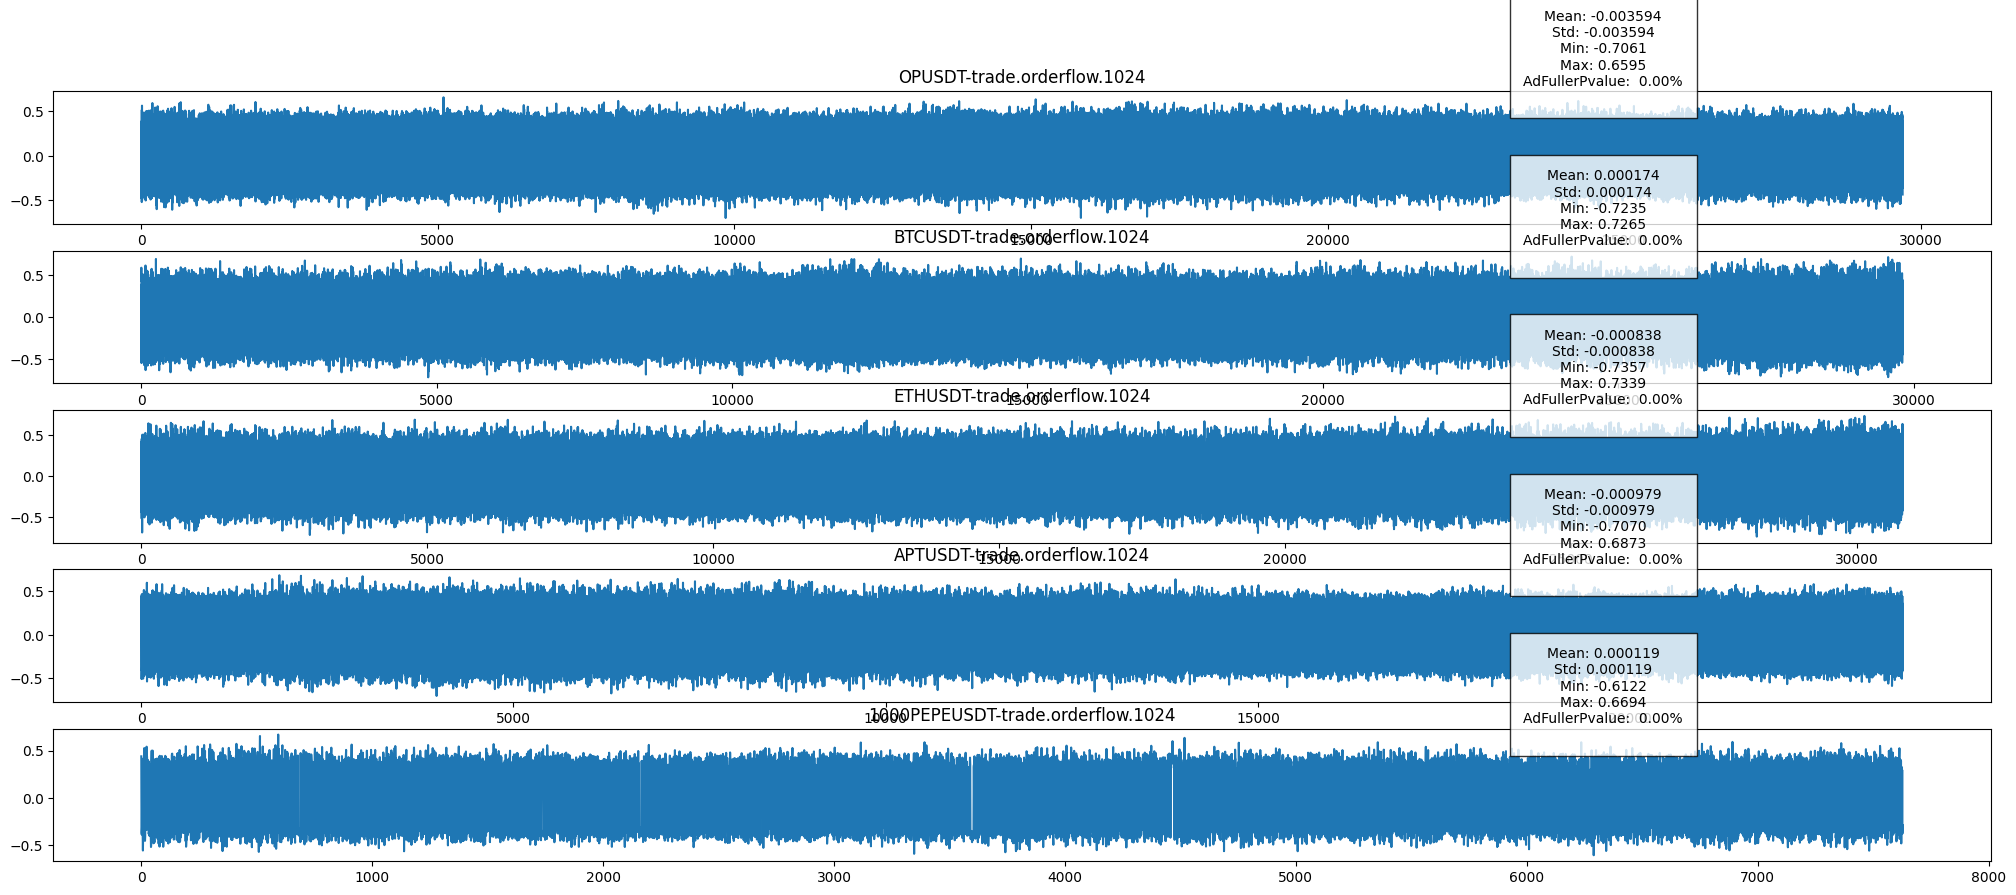

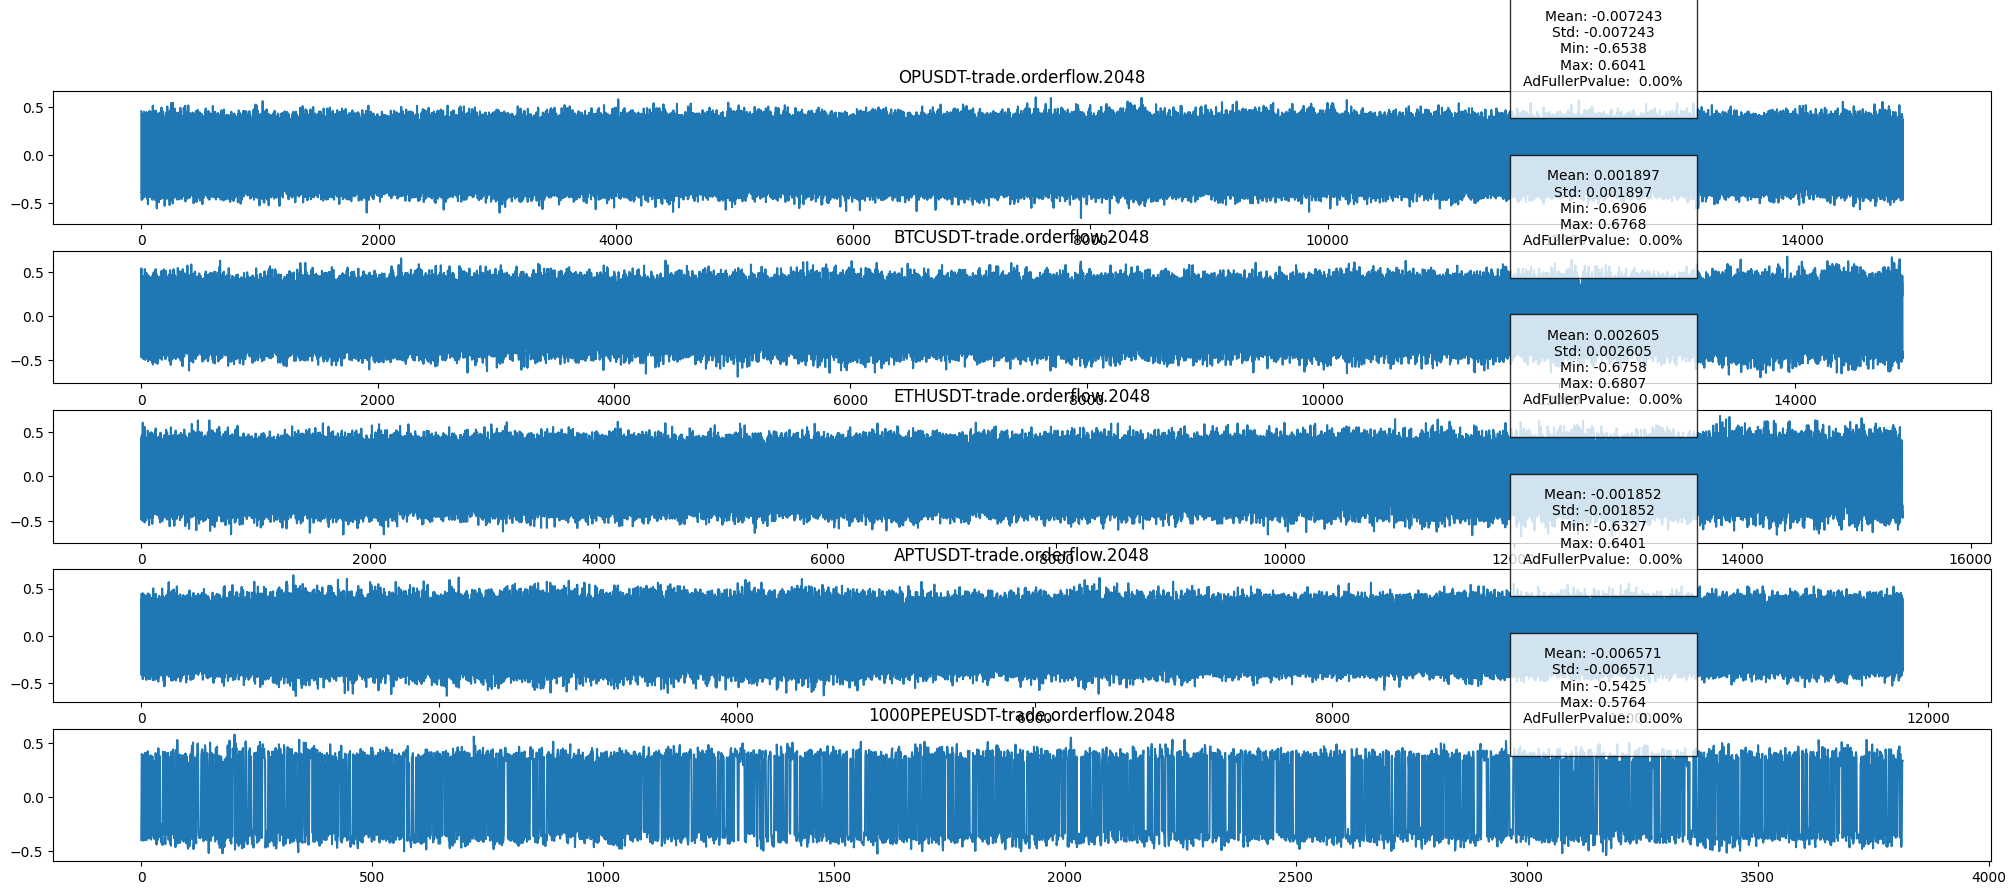

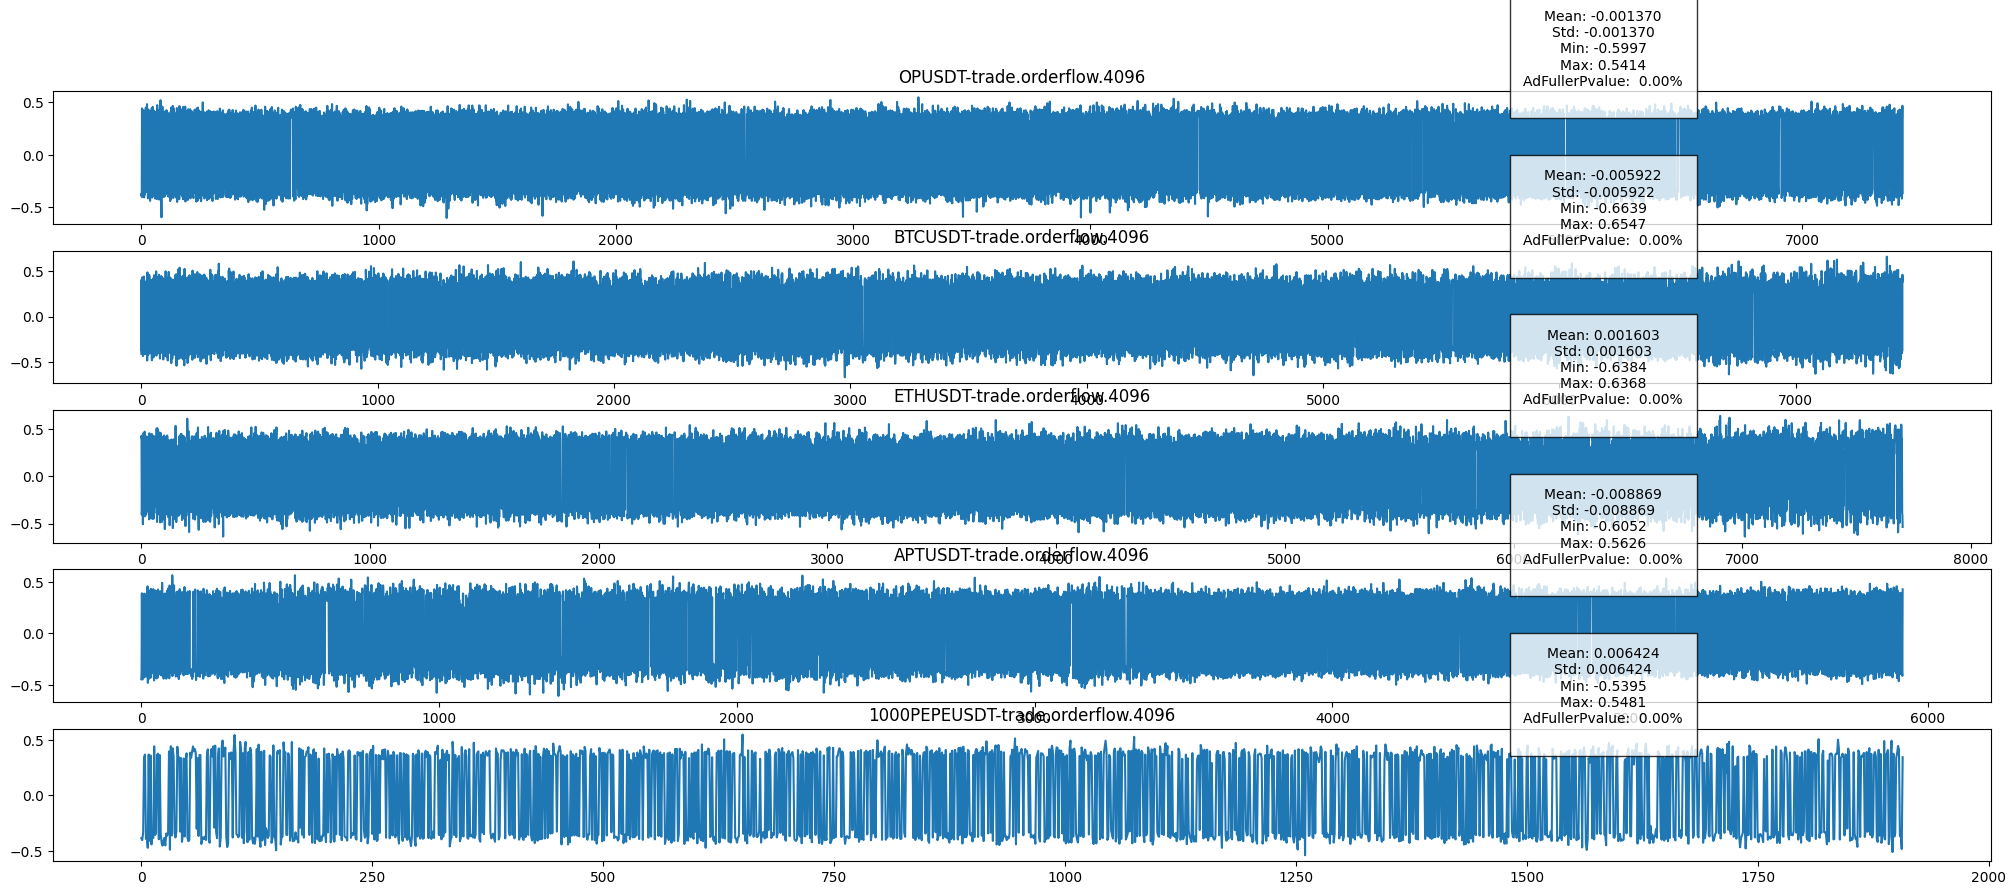

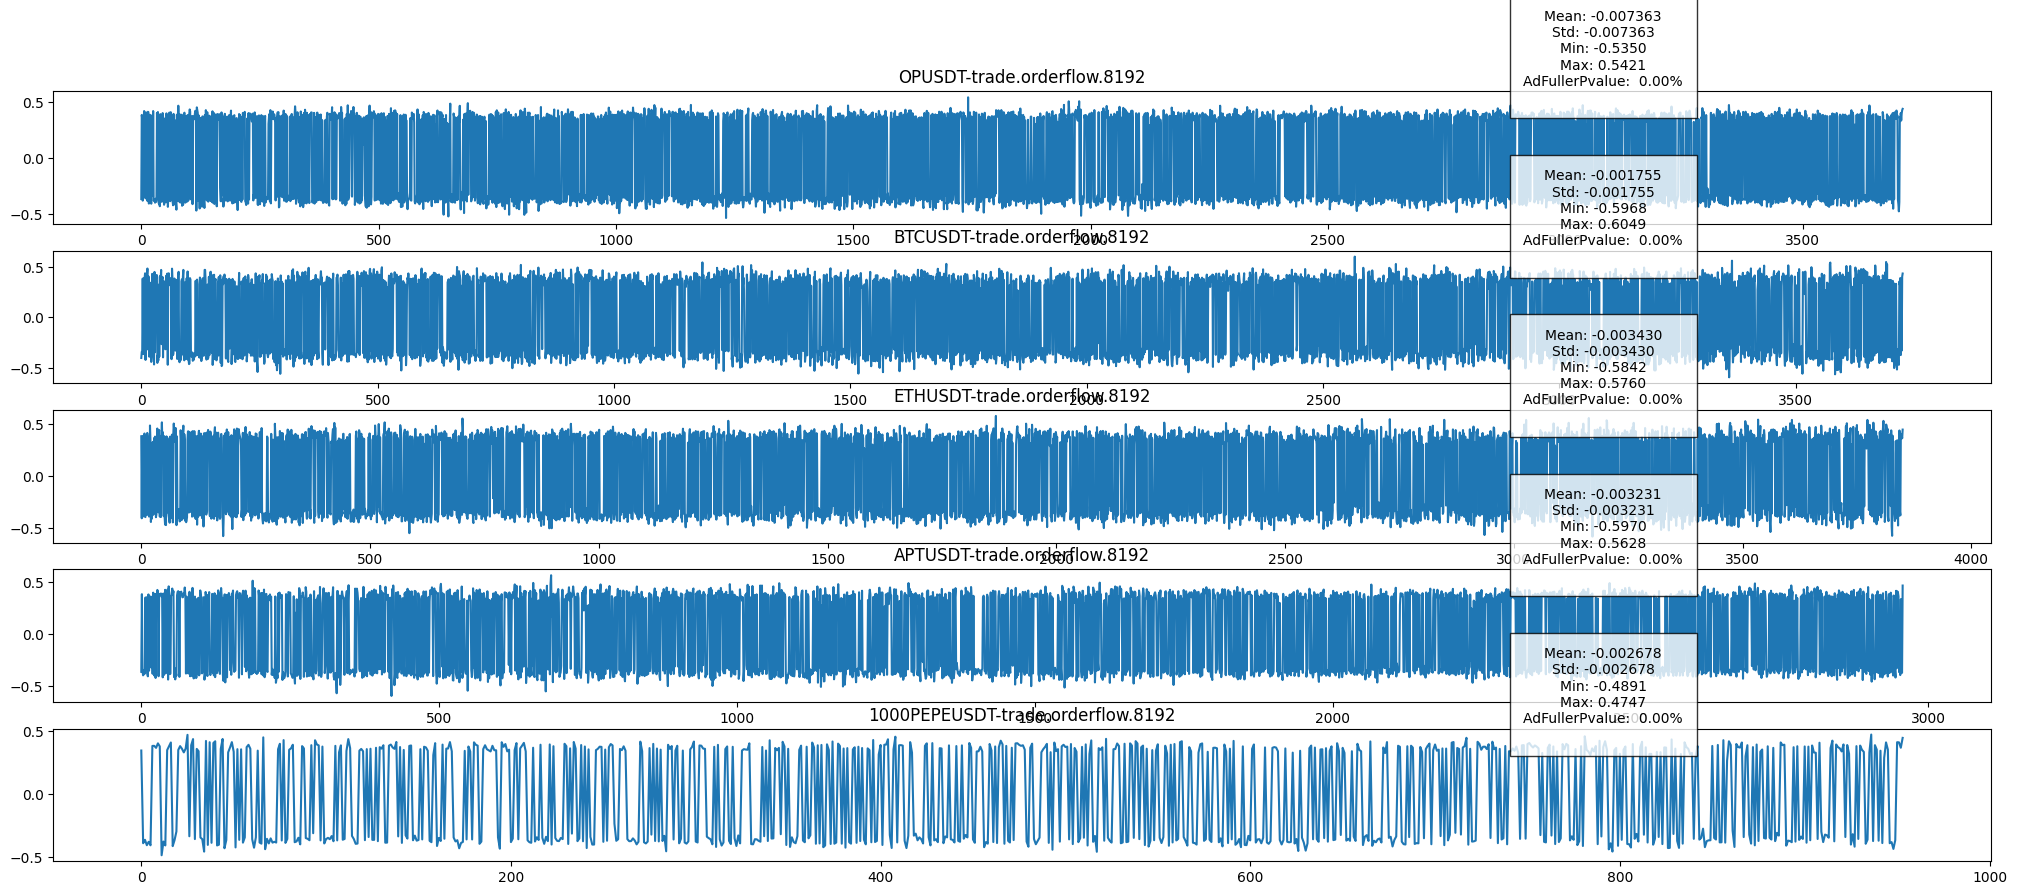

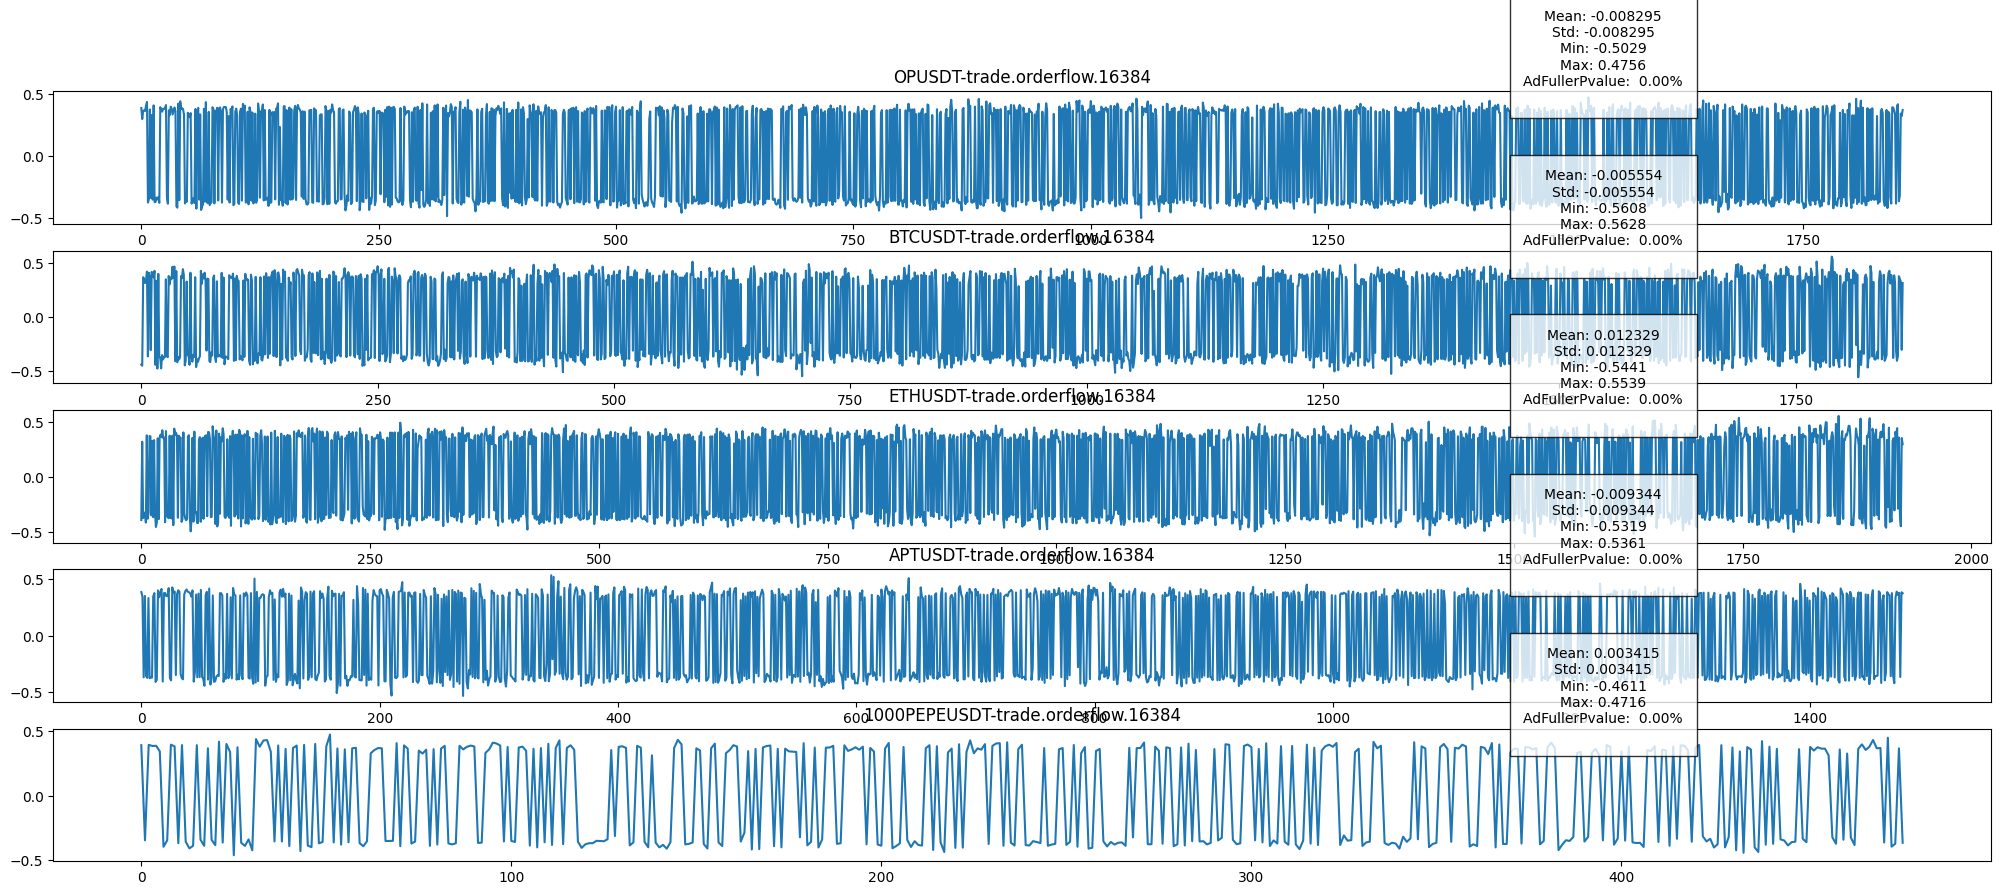

In [8]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)

        arr = arr[np.arange(0, T, period)]
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

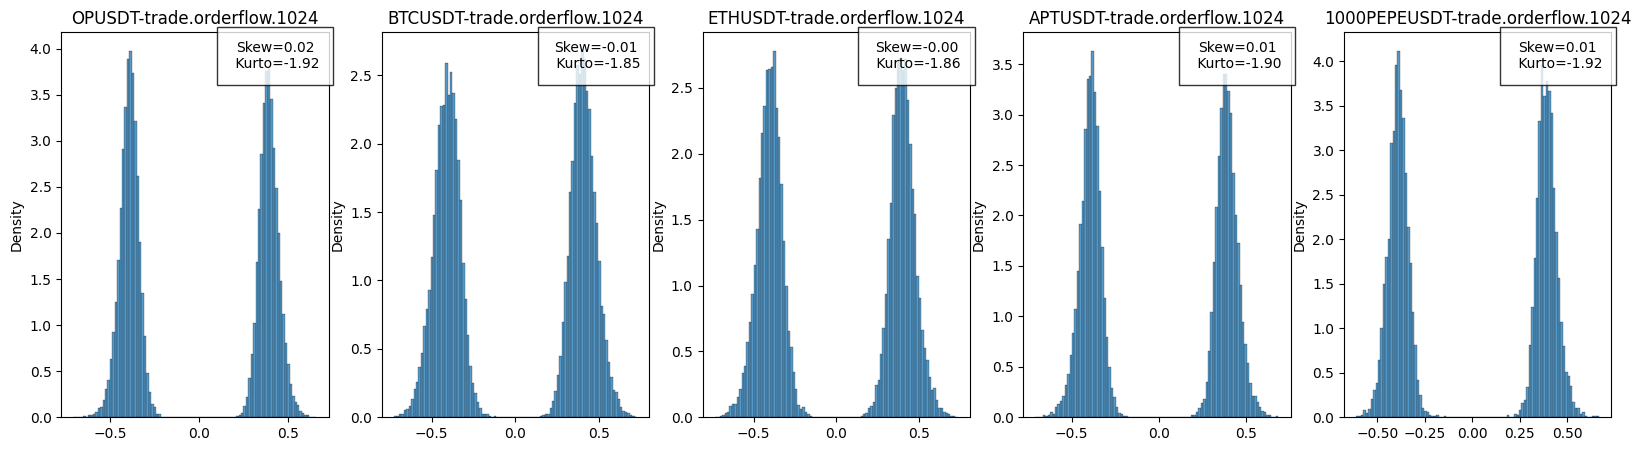

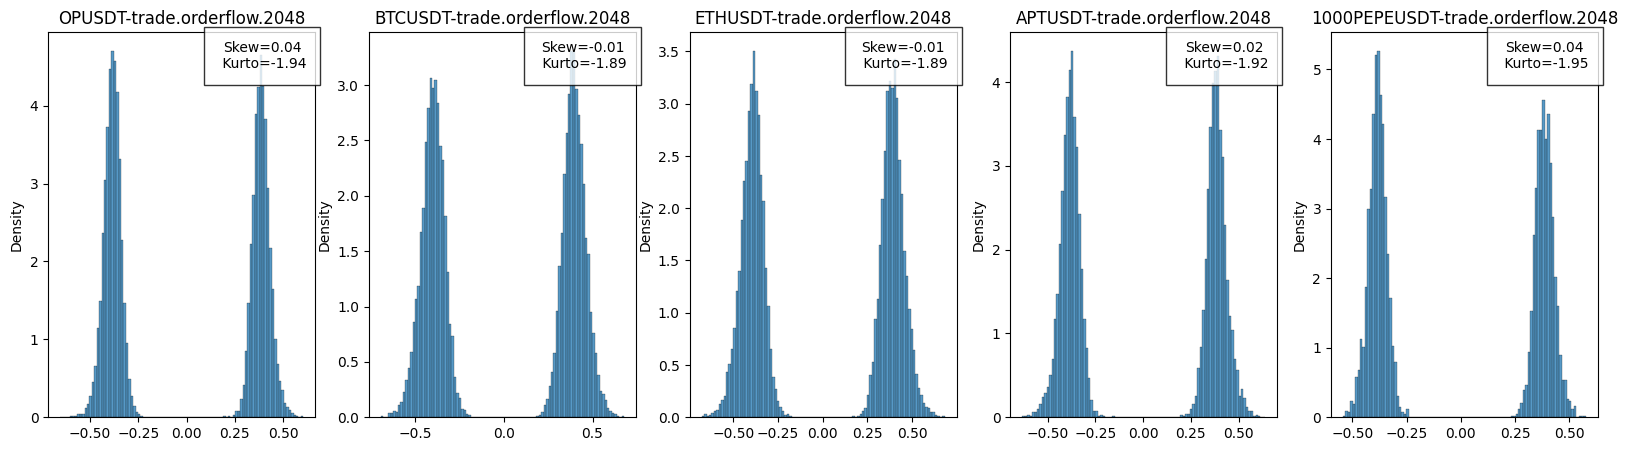

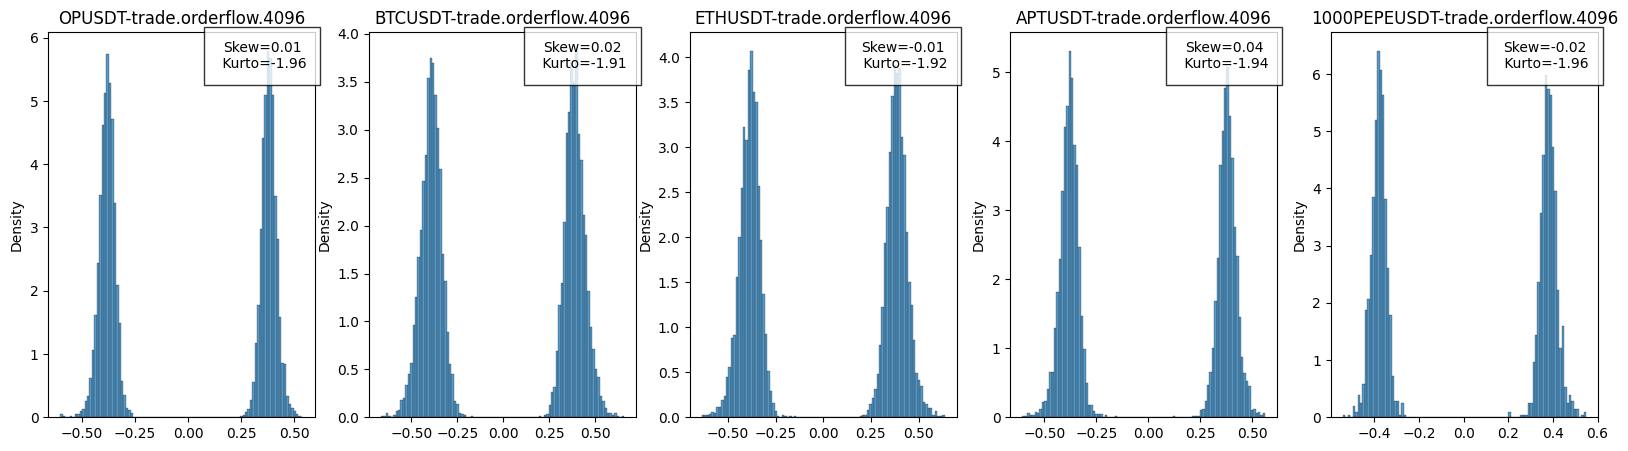

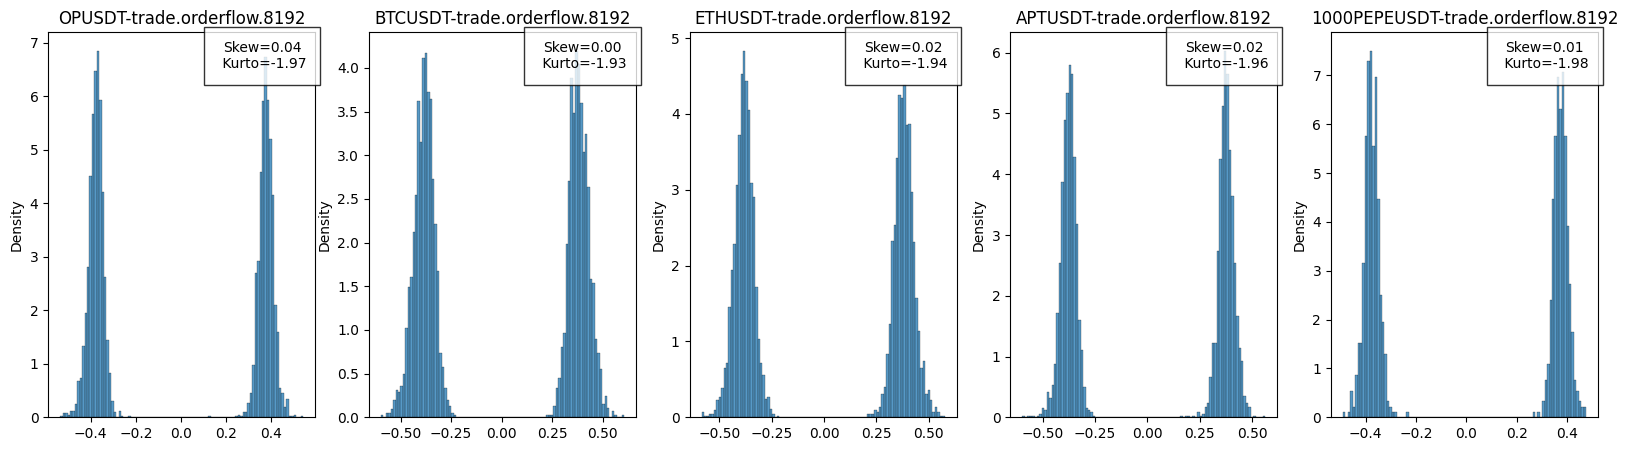

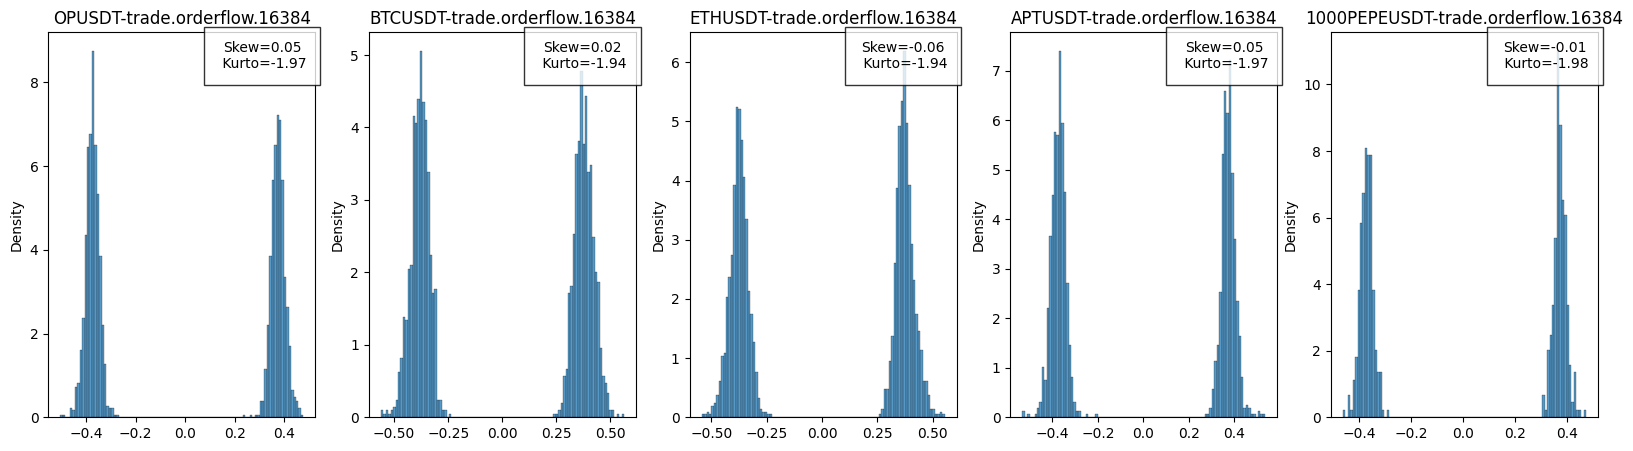

In [9]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        T = len(arr)
        arr = arr[np.arange(0, T, period)]
        skew = scipy.stats.skew(arr)
        kurto = scipy.stats.kurtosis(arr)
        summary_text = f"Skew={skew:.2f}\n Kurto={kurto:.2f}"
        # Plot the empirical histogram
        sns.histplot(arr, kde=False, bins=100, stat='density', label='Empirical', ax=axes[i])

        # # Fit a normal distribution to the data
        # mean, std = norm.fit(data)

        # # Generate values for the estimated normal distribution
        # x = np.linspace(min(data), max(data), 100)
        # y = norm.pdf(x, mean, std)

        # axes[i].plot(x, y, label='Estimated', color='red')
        axes[i].set_title(product + "-" + signal_name)
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

In [12]:
from research.orderbook_strategies.utils.product_info import product_info
import traceback

for product in product_list:
    all_dates = helper.get_dates_list(product)
    for period in periods:
        name = signal_name_format.format(period=period)
        helper.parLapply([name], helper.par_generate_alldates_signal, date_list=all_dates, product=product, period=2048)
        
for product in product_list:
    spread = product_info[product]["spread"]
    # tranct = product_info[product]["tranct"]
    tranct = 0
    tranct_ratio = product_info[product]["tranct.ratio"]
    all_dates = np.array(helper.get_dates_list(product))
    for period in periods:
        try:
            if product == "1000PEPEUSDT":
                split_str = "2023-06-10"
            else:
                split_str = "2023-04-01"
            factor_analysis.evaluate_signal(signal_name, all_dates, product,
                                            period=period,
                                            split_str=split_str,
                                            tranct=0,
                                            max_spread=spread*1.8,
                                            atr_filter=0.01,  # 波动大于1%
                                            save_path="signal_result_with_atr")
        except Exception as e:
            traceback.print_exc()
            print("Error in {}: {}".format(product, signal_name, period))
            

no file found for BTCUSDT trade.orderflow.1024 2023-07-25
no file found for BTCUSDT trade.orderflow.1024 2023-07-26
no file found for BTCUSDT trade.orderflow.1024 2023-07-24
no file found for BTCUSDT trade.orderflow.2048 2023-07-24
no file found for BTCUSDT trade.orderflow.2048 2023-07-26
no file found for BTCUSDT trade.orderflow.2048 2023-07-25
no file found for BTCUSDT trade.orderflow.4096 2023-07-24
no file found for BTCUSDT trade.orderflow.4096 2023-07-25
no file found for BTCUSDT trade.orderflow.4096 2023-07-26
no file found for BTCUSDT trade.orderflow.8192 2023-07-24
no file found for BTCUSDT trade.orderflow.8192 2023-07-26
no file found for BTCUSDT trade.orderflow.8192 2023-07-25
no file found for BTCUSDT trade.orderflow.16384 2023-07-24
no file found for BTCUSDT trade.orderflow.16384 2023-07-25
no file found for BTCUSDT trade.orderflow.16384 2023-07-26
evaludating signal trend OPUSDT trade.orderflow.1024 done
evaludating signal reverse OPUSDT trade.orderflow.1024 done
evaludati

In [15]:
res = []
df = pd.DataFrame()
bt_stra = "signal_result_with_atr"
for product in product_list:
    for period in periods:
        for direction in ["reverse", "trend"]:
            reverse = 1 if direction == "trend" else -1
            name = signal_name_format.format(period=period)
            p = (
                    helper.SIGNAL_RESULTS_PATH
                    / bt_stra
                    / f"{product}.{name}.{direction}.pkl"
                )
            signal_stat = helper.load(p)
            if signal_stat is None:
                print(f"{p} not found ")
                continue
            
            if tuple(signal_stat.keys())[0] != "train.stat":
                raise ValueError("wrong key")
            final_result_train, final_result_test = (
                signal_stat["train.stat"]["final_result"],
                signal_stat["test.stat"]["final_result"],
            )

            final_result_train["is_train"] = True
            final_result_train["reverse"] = reverse
            final_result_train["bt_stra"] = bt_stra

            final_result_test["is_train"] = False
            final_result_test["bt_stra"] = bt_stra
            final_result_test["reverse"] = reverse
            df = pd.concat([df, final_result_train, final_result_test], axis=0)

In [18]:
trades_signal_period = [signal_name_format.format(period=period) for period in periods]
results = factor_analysis.get_signal_performance_result(trades_signal_period, "signal_result_with_atr", product_list, 1e-4, 1)

trend_res = results['trend.signal.stat']
reve_res = results["reverse.signal.stat"]
signal_trend_res = trend_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']
signal_rever_res = reve_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']

trend_signals = signal_trend_res[(signal_trend_res - signal_rever_res) > 0].index
reverse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) < 0].index
nouse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) == 0].index

print("#trend={}, #reverse={}, #nouse={}".format(len(trend_signals), len(reverse_signals), len(nouse_signals)))

merge_res = pd.concat([trend_res.loc[np.isin(trend_res['signal'], trend_signals)], 
                       reve_res.loc[np.isin(reve_res['signal'], reverse_signals)]], 
                      axis=0)

display(merge_res.sort_values(by='trainSharpe', ascending=False))

#trend=2, #reverse=3, #nouse=0


,signal,reverse,num_good_product,good_product,good_product_sharpe,trainSharpe,testSharpe,trainSharpeV2,testSharpeV2,trainAvgDailyTradeNum,testAvgDailyTradeNum,sum_good_strat,avgTrainRet,avgTestRet,trainReturn,testReturn
4,trade.orderflow.16384,trend,2,"APTUSDT,1000PEPEUSDT","2.22,3.36",2.788643,-0.601328,2.220487,-0.885509,39.169348,20.806504,70,0.007023,-0.000546,0.436403,-0.059058
3,trade.orderflow.8192,trend,4,"OPUSDT,BTCUSDT,APTUSDT,1000PEPEUSDT","1.21,1.94,1.12,4.75",2.256348,-0.702182,1.209892,-0.200390,25.260021,9.916262,51,0.002534,-0.000451,0.251056,-0.040486
2,trade.orderflow.4096,reverse,2,"ETHUSDT,1000PEPEUSDT","1.48,2.84",2.160974,-0.252946,1.477797,0.603479,12.618737,3.415641,18,0.008002,-0.001694,0.385578,-0.094861
0,trade.orderflow.1024,reverse,4,"BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT","1.41,1.61,0.55,3.05",1.656083,0.795944,1.413557,1.207106,39.041669,12.160476,18,0.005843,0.000429,0.431903,0.058698
1,trade.orderflow.2048,trend,3,"OPUSDT,APTUSDT,1000PEPEUSDT","0.42,2.14,1.52",1.362813,-1.843454,0.420981,-2.202814,46.797147,11.581891,14,0.002299,-0.001683,0.271160,-0.137893
